# Optic flow connectivity analysis in FAFB

This script is about getting optic flow vectors in the medulla based on the main inputs of direction-selective cells in the medulla

In [ ]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
import os
from fafbseg import flywire

In [24]:
# Custom functions
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

# 1. Getting the data of interest

In [25]:
# Some user parameters
cell_of_interest = 'Mi1'

In [112]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_metadata.csv.gz'
filePath = os.path.join(dataPath,fileName)
metadata = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_connections.csv.gz'
filePath = os.path.join(dataPath,fileName)
connections = pd.read_csv(filePath, compression='gzip')
connections.rename(columns={"from cell id ": "from_cell_id ","to cell id": "to_cell_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

#Brief overview:
print('\n----------------- column data -----------------:\n')
print(columns_id_data)
print('\n------------------ metadata ------------------:\n')
print(metadata)
print('\n----------------- connections ----------------:\n')
print(connections)
print('\n----------------- coordinates ----------------:\n')
print(columns_id_coordinates)


----------------- column data -----------------:

                  root_id cell_type column_id
0      720575940596125868       T5c        97
1      720575940599333574       Tm1       355
2      720575940599457990       T4b       247
3      720575940599459782       T5b       513
4      720575940599704006       T5a       331
...                   ...       ...       ...
23447  720575940661201025        R8       701
23448  720575940661224065       T4a       390
23449  720575940661245825        C3       183
23450  720575940661264001        C3        38
23451  720575940661284993        R8       694

[23452 rows x 3 columns]

------------------ metadata ------------------:

                 attribute    value
0   number of cells mapped    22578
1  synapses inside columns  1381915
2   synapses cross columns   811545

----------------- connections ----------------:

              from cell id          to_cell_id  synapses
0       720575940596125868  720575940622955561         2
1       72057

# 2. Creating the hexagonal grid

## 2.1 Getting the cell of interest column coordinates as the reference for creating a 2D lattice

In [113]:
# Looking deeply at the match between individual cells and individual columns

cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_of_interest]
number_unique_cells = len(cells_columns['root_id'].unique())
number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label"

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df length: {len(df)}')
display(df.head())

Total number of unique cells: 796
Total number of unique columns: 795
Missmatch: 1
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df length: 796


root_id cell_type column_id   p   q  x   y
0  720575940603042272       Mi1         1  12   1  6  13
1  720575940603200428       Mi1         2   9  -7  8   2
2  720575940603327916       Mi1         3 -12   0 -6 -12
3  720575940603935334       Mi1         4  -6 -15  5 -21
4  720575940604151008       Mi1         6   0  -4  2  -4

## 2.2 Importing other more data about the cells of interest

In [7]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'labels.csv.gz'
filePath = os.path.join(dataPath,fileName)
labels_data = pd.read_csv(filePath, compression='gzip')

In [9]:
df2 = pd.merge(labels_data, columns_id_data, on='root_id', how='outer')
filtered_df2  = df2.drop_duplicates(subset='root_id', keep='first').copy()
mi1_df2 = filtered_df2[filtered_df2['cell_type'] == 'Mi1'].copy()
display(mi1_df2.head())

root_id                                             label  \
192  720575940603042272  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
238  720575940603200428  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
272  720575940603327916  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
631  720575940603935334  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
782  720575940604151008  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   

     user_id                position  supervoxel_id  label_id  \
192    392.0  [739864 206272  81960]   8.331962e+16   76738.0   
238    392.0  [709316 297120  66680]   8.282855e+16   77514.0   
272    392.0  [833308 358980 202680]   8.494071e+16   76614.0   
631    392.0  [684784 347004 123280]   8.240723e+16   76740.0   
782    392.0  [771472 320404  81080]   8.388449e+16   77389.0   

            date_created       user_name user_affiliation cell_type column_id  
192  2023-01-31 22:14:43  Krzysztof Kruk          Eyewire       Mi1         1  
238  2023-02-01 14:00:22  Krzysztof Kruk          Eyewire       Mi1         2  
272  2023-01-31 22:14:34  Krzysztof Kruk          Eyewire       Mi1         3  
631  2023-01-31 22:14:44  Krzysztof Kruk          Eyewire       Mi1         4  
782  2023-02-01 14:00:10  Krzysztof Kruk          Eyewire       Mi1         6

In [12]:
#checking numbers with Mi1 example
print('Number of unique Mi1 ids in df2: ')
print(len(df2[df2['cell_type'] == 'Mi1'].root_id.unique()))
print('Number of  Mi1 ids in filtered_df2: ')
print(len(filtered_df2[filtered_df2['cell_type'] == 'Mi1'].root_id))


Number of unique Mi1 ids in df: 
796
Number of  Mi1 ids in filtered_df: 
796


In [19]:
# Getting Mi1s positions (soma locations)

# Convert positions to NumPy array for easier manipulation
positions_somas = np.array(mi1_df2.position.values) # These are apparently soma locations!
positions_somas = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_somas])

In [ ]:
# Getting Mi1 positions (terminals)

'''
All in a loop across mi1 cells:
1. Getting pre-synaptic sites
2. PCA to get the depth axis of each Mi1
3. Select the last points belonging to layer M9-10
4. Calculate a centroid
5. Define this centroid as the Mi1 terminal location
'''

terminal_position_ls = []
curr_id_ls = mi1_df2.root_id.tolist()
output_df2 = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)
combine_xyz(output_df2)

for root_id in mi1_df2.root_id:
    # Getting single Mi1 re synaptic sites
    curr_df2 = output_df2[output_df2.pre_pt_root_id == int(root_id)]
    positions_pre_syn = np.array(curr_df2.pre_pt_position.values)
    positions_pre_syn = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_pre_syn])

    #Doing PCA
    
    pass

# Seb coding here



In [17]:
output_df2.head()

pre_pt_root_id     post_pt_root_id  cleft_score   pre_x   pre_y  \
0  720575940604687532  720575940530754898          152  799736  365992   
1  720575940604687532  720575940630392428          137  799264  365656   
2  720575940604687532  720575940618949848          137  799644  365632   
3  720575940604687532  720575940624900327          141  797244  364280   
4  720575940604687532  720575940621019501          123  799360  365628   

    pre_z  post_x  post_y  post_z       id neuropil  \
0  198880  799872  366040  198840  1904109     ME_R   
1  198560  799196  365568  198560  1904066     ME_R   
2  198280  799696  365536  198280  1904025     ME_R   
3  198280  797360  364260  198280  1904023     ME_R   
4  198320  799316  365556  198280  1904024     ME_R   

              post_pt_position              pre_pt_position  
0  [199968.0, 91510.0, 4971.0]  [199934.0, 91498.0, 4972.0]  
1  [199799.0, 91392.0, 4964.0]  [199816.0, 91414.0, 4964.0]  
2  [199924.0, 91384.0, 4957.0]  [199911.0, 91408.0, 4957.0]  
3  [199340.0, 91065.0, 4957.0]  [199311.0, 91070.0, 4957.0]  
4  [199829.0, 91389.0, 4957.0]  [199840.0, 91407.0, 4958.0]

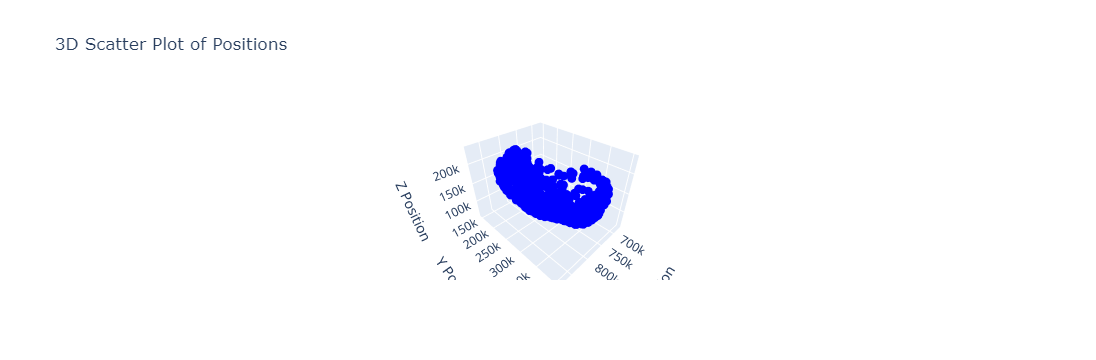

In [20]:
# Quick visualization

import plotly.graph_objs as go

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='blue')
)

layout = go.Layout(
    title='3D Scatter Plot of Positions',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()




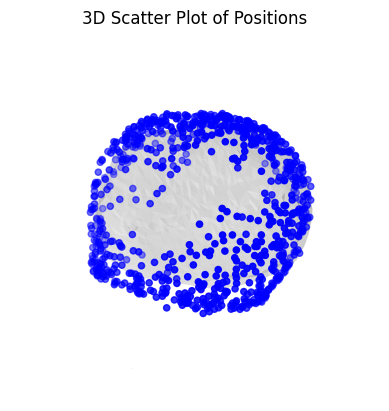

In [21]:
# Checking positions relative to the medulla neuropile

import navis
neurpile_mesh = 'ME_L'

#For top view
mesh_azim =16# -18 for ME_R, 16 (600) for ME_L
mesh_elev = -50 # -148 for ME_R, -50 (-489) for ME_L 

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create a 3D scatter plot

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

#Plot the mesh
OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

# Plot the data
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Set title
ax.set_title('3D Scatter Plot of Positions')

plt.show()

### Working on the 2D (hexagonal) grid / lattice

In [171]:
## For creating the 2d lattice

def plot_hex_grid(x, y, hex_size=1.0, spacing=1.5, fig_size=(10, 10), labels=None, label_type='column_id', text_size=10):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_aspect('equal')
    
    hexagons = []
    
    # Function to calculate vertices of hexagon
    def hexagon_vertices(x_center, y_center):
        angles = np.linspace(0, 2*np.pi, 7) + np.pi/8  # Add pi/8 to rotate by 45 degrees
        vertices = [(x_center + hex_size * np.cos(angle), y_center + hex_size * np.sin(angle)) for angle in angles]
        return vertices
    
    # Plot hexagons
    for i in range(len(x)):
        vertices = hexagon_vertices(x[i], y[i])
        hexagon = Polygon(vertices, edgecolor='black', linewidth=1, facecolor='none')
        ax.add_patch(hexagon)
        hexagons.append(hexagon)
        
        # Determine label based on label_type
        if label_type == 'manual_labels' and labels:
            label = labels[i]
        elif label_type == 'xy':
            label = f'({x[i]}, {y[i]})'
        else:
            label = ''
        
        # Add label in the center of the hexagon
        if label:
            x_center = x[i]
            y_center = y[i]
            ax.text(x_center, y_center, label, ha='center', va='center', fontsize=text_size)
    
    # Set limits based on the hexagon positions
    ax.set_xlim(min(x) - hex_size - spacing, max(x) + hex_size + spacing)
    ax.set_ylim(min(y) - hex_size - spacing, max(y) + hex_size + spacing)
    
    ax.autoscale_view()
    
    return fig, ax, hexagons

def draw_vector(ax, x_start, y_start, x_end, y_end, linewidth=2, head_size=0.5, **kwargs):
    """Draw an arrow (vector) from one (x, y) coordinate to another with specified linewidth and arrowhead size."""
    arrow_style = f'->,head_width={head_size},head_length={head_size * 1.5}'
    arrow_style = f'-|>,head_width={head_size},head_length={head_size * 1.5}'
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle=arrow_style, linewidth=linewidth, fill=True, **kwargs))


def calculate_new_x_values(original_x, original_y, start_key=-16, end_key=17, relative_change=0.5):
    shift_dict = {}

    # Iterate through the range from start_key to end_key (inclusive)
    for i in range(start_key, end_key + 1):
        # Calculate the corresponding value based on relative_change
        value = (i - start_key) * relative_change
        # Assign the key-value pair to the dictionary
        shift_dict[i] = value

    # Initialize a list to store the new_x values
    new_x_values = []

    # Iterate through each pair of original_x and original_y
    for x, y in zip(original_x, original_y):
        if y in shift_dict:
            # Get the corresponding relative_change from shift_dict
            relative_change = shift_dict[y]
            # Calculate the new_x value
            new_x = x - relative_change
            # Append the new_x value to the list
            new_x_values.append(new_x)
        else:
            # Handle case where y is not found in shift_dict (optional)
            # You may choose to skip these or handle them differently
            new_x_values.append(x)  # Keep original x value if no match found

    return new_x_values


In [216]:
## Plotting on the 2D lattice

# Example usage
#x = [0, 2, 12, 9, -12, -6, 0, 3, 17, 0, 7, -13]
#y = [0, 0, 1, -7, 0, -15, -4, -9, 9, 9, 17, -2]
#labels = ['0', '1', '2', '3', '4', '6', '7', '8', '9', '779', '10']

# Given coordinates and labels (data)
# Original coordinates
original_x = df.p.tolist()
original_y = df.q.tolist()

# "manual_labels" column ids
labels = df.column_id.tolist() 

# "manual_labels" original coordinates
labels = list(zip(original_x, original_y)) 
labels = [f"({x}, {y})" for x, y in labels]

new_x_values = calculate_new_x_values(original_x, original_y, start_key=-16, end_key=17, relative_change=0.5)
df['new_x'] = new_x_values

Color: red, end: (-7.5,-1)
Color: blue, end: (-8.5,1)
Color: green, end: (-7.5,2)
Color: yellow, end: (-8.5,-2)
Color: purple, end: (-7.0,1)
Color: orange, end: (-9.0,-1)


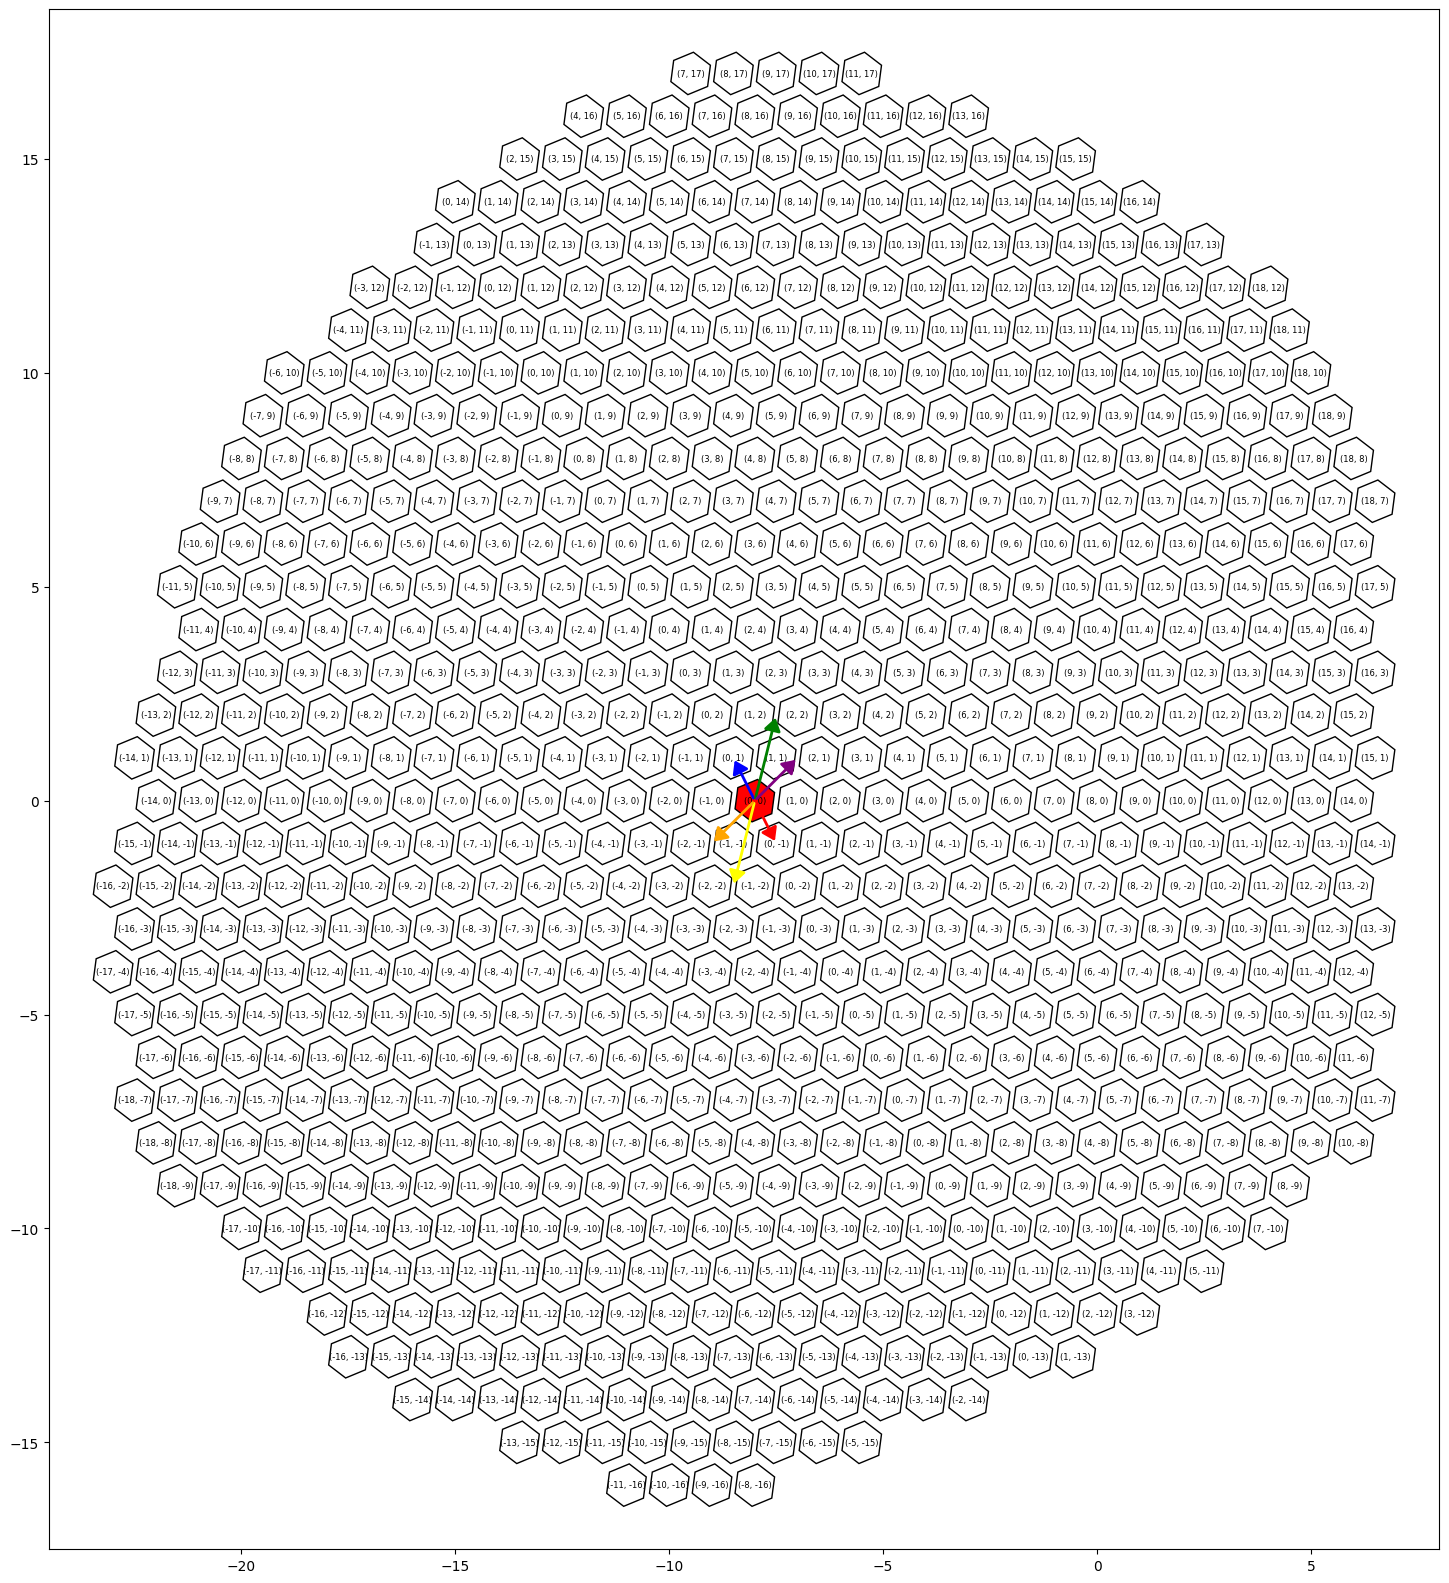

In [223]:

original_x = new_x_values
fig, ax, hexagons = plot_hex_grid(new_x_values, original_y, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition

color_in_x = 0
color_in_y = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_x, original_y)):
    new_x_pos = calculate_new_x_values([color_in_x], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_x_pos[0] and y_pos == color_in_y:
        hexagon.set_facecolor('red')

# Draw vector from hexagon (0, 0) to hexagon (2, 0)

# Choose column_ids
start_ids = [628,628,628,628,628,628]
end_ids = [120, 486, 747,38,250,627] # problems with 250
color_ls = ["red", "blue", "green", "yellow", "purple", "orange"]
start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_x = df[df.column_id == str(start_id)].new_x.values[0]
    start_id_y = df[df.column_id == str(start_id)].y.values[0]
    start_coords_ls.append((start_id_x,start_id_y))

    end_id_x = df[df.column_id == str(end_id)].new_x.values[0]
    end_id_y = df[df.column_id == str(end_id)].y.values[0]
    end_coords_ls.append((end_id_x,end_id_y))

    

#Drawing vectors
i = 0
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_ls[i])
    print(f'Color: {color_ls[i]}, end: ({x_end},{y_end})')
    i += 1
    


plt.show()

In [176]:
df

root_id cell_type column_id   p   q  x   y  new_x
0    720575940603042272       Mi1         1  12   1  6  13    3.5
1    720575940603200428       Mi1         2   9  -7  8   2    4.5
2    720575940603327916       Mi1         3 -12   0 -6 -12  -20.0
3    720575940603935334       Mi1         4  -6 -15  5 -21   -6.5
4    720575940604151008       Mi1         6   0  -4  2  -4   -6.0
..                  ...       ...       ...  ..  .. ..  ..    ...
791  720575940652626934       Mi1       767  13  15 -1  28   -2.5
792  720575940655096481       Mi1       769 -18  -9 -4 -27  -21.5
793  720575940655608481       Mi1       771 -17 -10 -3 -27  -20.0
794  720575940655611553       Mi1       772   5   7 -1  12   -6.5
795  720575940660975745       Mi1       296 -10  -8 -1 -18  -14.0

[796 rows x 8 columns]

In [198]:
zip(-8,-9,5)

-9.5

In [ ]:
'''

OLD, FIRST ATTEMPTS

'''



def hexagon_vertices(center, size):
    """Return the vertices of a hexagon given its center and size."""
    angle_offset = np.pi / 6
    return [
        (center[0] + size * np.cos(np.pi / 3 * i + angle_offset),
         center[1] + size * np.sin(np.pi / 3 * i + angle_offset))
        for i in range(6)
    ]

def draw_hexagon(ax, center, size, **kwargs):
    """Draw a single hexagon at the given center with the given size and return the hexagon object."""
    vertices = hexagon_vertices(center, size)
    hexagon = plt.Polygon(vertices, **kwargs)
    ax.add_patch(hexagon)
    return hexagon

def p_q_to_xy(p, q, size, spacing):
    """Convert (p, q) coordinates to (x, y) coordinates for plotting with spacing."""
    x = size * (3/2 * p) * spacing
    y = size * (np.sqrt(3) * (q + p/2)) * spacing
    return (x, y)



def draw_hex_grid(p_values, q_values, column_ids=None, size=1, label_type='pq', text_size=8, figsize=(10, 10), spacing=1.1, predefined_coordinates=None):
    """
    Draw the hexagonal grid with labels inside hexagons and return figure, axes, hexagons, and coordinates.
    
    Parameters:
    - p_values, q_values: Lists of (p, q) coordinates for each hexagon.
    - column_ids: Optional list of column IDs for labels.
    - size: Size of each hexagon.
    - label_type: Type of label ('pq' for (p, q), 'column_ids' for column IDs).
    - text_size: Font size for labels.
    - figsize: Figure size.
    - spacing: Spacing factor between hexagons.
    - predefined_coordinates: Optional list of (x, y) tuples for predefined coordinates.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    hexagons = []
    coordinates = []
    
    if predefined_coordinates is None:
        for i, (p, q) in enumerate(zip(p_values, q_values)):
            x, y = p_q_to_xy(p, q, size, spacing)
            hexagon = draw_hexagon(ax, (x, y), size, edgecolor='k', facecolor='none')
            hexagons.append(hexagon)
            coordinates.append((x, y))

            if label_type == 'pq':
                label = f"({p},{q})"
            elif label_type == 'column_ids' and column_ids is not None:
                label = str(column_ids[i])
            else:
                label = ""

            ax.text(x, y, label, ha='center', va='center', fontsize=text_size)
    else:
        for i, (x, y) in enumerate(predefined_coordinates):
            hexagon = draw_hexagon(ax, (x, y), size, edgecolor='k', facecolor='none')
            hexagons.append(hexagon)
            coordinates.append((x, y))

            if label_type == 'pq':
                label = f"({p_values[i]},{q_values[i]})"
            elif label_type == 'column_ids' and column_ids is not None:
                label = str(column_ids[i])
            else:
                label = ""

            ax.text(x, y, label, ha='center', va='center', fontsize=text_size)

    ax.autoscale()
    return fig, ax, hexagons, coordinates

def draw_vector(ax, p_start, q_start, p_end, q_end, size=1, spacing=1.1, **kwargs):
    """Draw an arrow (vector) from one (p, q) coordinate to another."""
    x_start, y_start = p_q_to_xy(p_start, q_start, size, spacing)
    x_end, y_end = p_q_to_xy(p_end, q_end, size, spacing)
    
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle='->', **kwargs))



#User parameters to fix:
_spacing = 2 # 1.3 when user self calculated coordinates (_predefined_coordinates = None)
_label_type =  'pq' # 'pq' , 'column_ids'
hex_size = 3 # 2 when user self calculated coordinates (_predefined_coordinates = None)


#For drawing in a loop
_p_start_ls = [0,0,0]
_q_start_ls = [0,1,2]

_p_end_ls = [2,2,2]
_q_end_ls = [0,1,2]

#Data
p_values = df.p.tolist()
q_values = df.q.tolist()
column_ids = df.column_id.tolist()

_coords_x = df.x.tolist()
_coords_y = df.y.tolist()


mult_factor = 6
_coords_x = [i*mult_factor for i in _coords_x] 
_coords_y = [i*mult_factor for i in _coords_y] 


_predefined_coordinates = list(zip(_coords_x , _coords_y))# None
predefined_coordinates = None

# Draw the grid with (p, q) labels and custom figure size, spacing
fig, ax, hexagons, coordinates = draw_hex_grid(p_values, q_values, column_ids, size=hex_size, label_type=_label_type, text_size=6, figsize=(20, 20), spacing=_spacing, predefined_coordinates=_predefined_coordinates)
# Add the x, y coordinates to the DataFrame
df['coord_x'] = [x for x, y in coordinates]
df['coord_y'] = [y for x, y in coordinates]

# Example of modifying the plot afterward
# Coloring the hexagon at coordinate p = 0 and q = 0 in red
for hexagon, (p, q) in zip(hexagons, zip(p_values, q_values)):
    if p == 0 and q == 0:
        hexagon.set_facecolor('red')

# Draw an arrow from (p=0, q=0) to (p=2, q=-1)
draw_vector(ax, p_start=0, q_start=0, p_end=2, q_end=-1, size=2, spacing=_spacing, color='blue', linewidth=2)

plt.show()

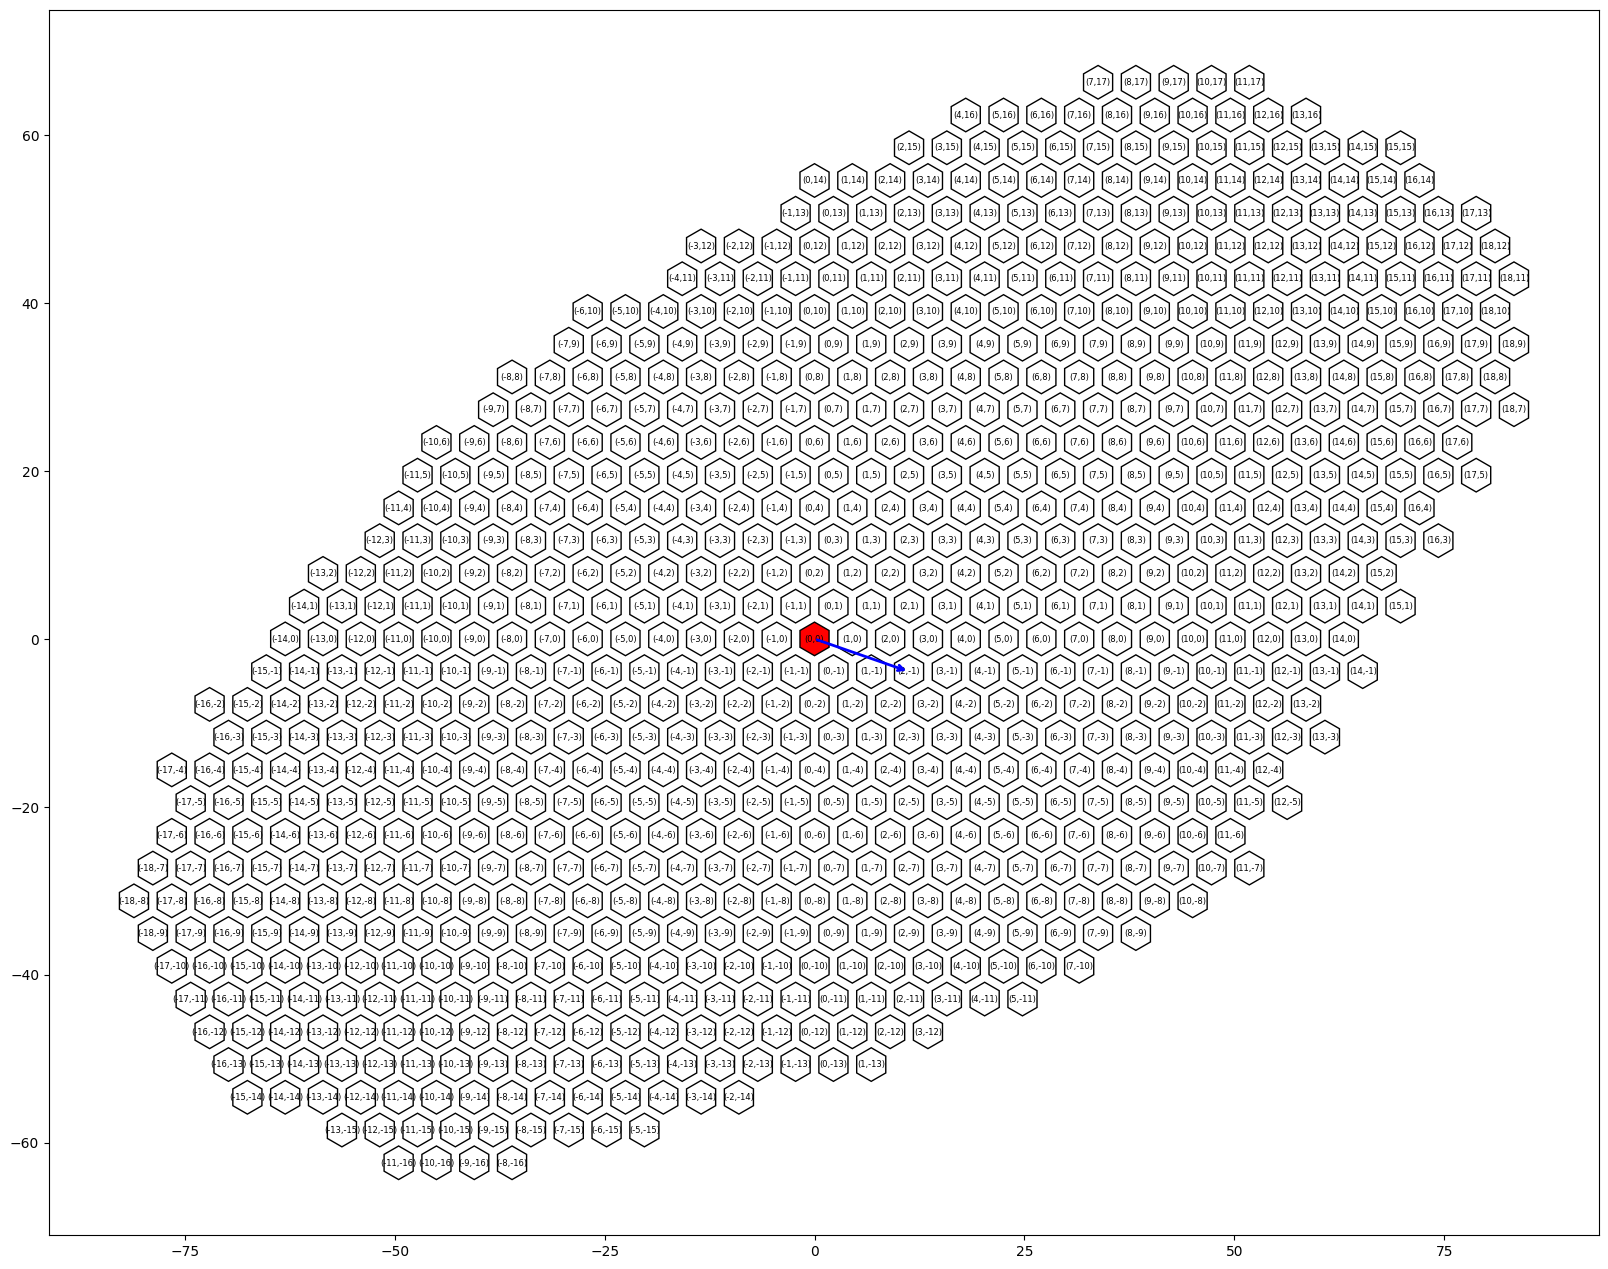

In [69]:
'''

OLD, FIRST ATTEMPTS

'''




def hexagon_vertices(center, size):
    """Return the vertices of a hexagon given its center and size."""
    angle_offset = np.pi / 6
    return [
        (center[0] + size * np.cos(np.pi / 3 * i + angle_offset),
         center[1] + size * np.sin(np.pi / 3 * i + angle_offset))
        for i in range(6)
    ]

def draw_hexagon(ax, center, size, **kwargs):
    """Draw a single hexagon at the given center with the given size and return the hexagon object."""
    vertices = hexagon_vertices(center, size)
    hexagon = plt.Polygon(vertices, **kwargs)
    ax.add_patch(hexagon)
    return hexagon

def p_q_to_xy(p, q, size, spacing):
    """Convert (p, q) coordinates to (x, y) coordinates for plotting with spacing."""
    x = size * np.sqrt(3) * (p + 0.5 * (q % 2)) * spacing
    y = size * 1.5 * q * spacing
    return (x, y)

def draw_hex_grid(p_values, q_values, column_ids=None, size=1, label_type='pq', text_size=8, figsize=(10, 10), spacing=1.1, predefined_coordinates=None):
    """
    Draw the hexagonal grid with labels inside hexagons and return figure, axes, hexagons, and coordinates.
    
    Parameters:
    - p_values, q_values: Lists of (p, q) coordinates for each hexagon.
    - column_ids: Optional list of column IDs for labels.
    - size: Size of each hexagon.
    - label_type: Type of label ('pq' for (p, q), 'column_ids' for column IDs).
    - text_size: Font size for labels.
    - figsize: Figure size.
    - spacing: Spacing factor between hexagons.
    - predefined_coordinates: Optional list of (x, y) tuples for predefined coordinates.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    hexagons = []
    coordinates = []
    
    if predefined_coordinates is None:
        for i, (p, q) in enumerate(zip(p_values, q_values)):
            x, y = p_q_to_xy(p, q, size, spacing)
            hexagon = draw_hexagon(ax, (x, y), size, edgecolor='k', facecolor='none')
            hexagons.append(hexagon)
            coordinates.append((x, y))

            if label_type == 'pq':
                label = f"({p},{q})"
            elif label_type == 'column_ids' and column_ids is not None:
                label = str(column_ids[i])
            else:
                label = ""

            ax.text(x, y, label, ha='center', va='center', fontsize=text_size)
    else:
        for i, (x, y) in enumerate(predefined_coordinates):
            hexagon = draw_hexagon(ax, (x, y), size, edgecolor='k', facecolor='none')
            hexagons.append(hexagon)
            coordinates.append((x, y))

            if label_type == 'pq':
                label = f"({p_values[i]},{q_values[i]})"
            elif label_type == 'column_ids' and column_ids is not None:
                label = str(column_ids[i])
            else:
                label = ""

            ax.text(x, y, label, ha='center', va='center', fontsize=text_size)

    ax.autoscale()
    return fig, ax, hexagons, coordinates

def draw_vector(ax, p_start, q_start, p_end, q_end, size=1, spacing=1.1, **kwargs):
    """Draw an arrow (vector) from one (p, q) coordinate to another."""
    x_start, y_start = p_q_to_xy(p_start, q_start, size, spacing)
    x_end, y_end = p_q_to_xy(p_end, q_end, size, spacing)
    
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle='->', **kwargs))

# User parameters
_spacing = 1.3  # Adjusted spacing for honeycomb pattern
_label_type = 'pq'  # 'pq' or 'column_ids'
hex_size = 2  # Hexagon size


#Data
p_values = df.p.tolist()
q_values = df.q.tolist()
column_ids = df.column_id.tolist()

_coords_x = df.x.tolist()
_coords_y = df.y.tolist()

_predefined_coordinates = list(zip(_coords_x , _coords_y))# None
predefined_coordinates = None


mult_factor = 6
_coords_x = [i*mult_factor for i in _coords_x] 
_coords_y = [i*mult_factor for i in _coords_y] 

# Draw the grid with (p, q) labels and custom figure size, spacing
fig, ax, hexagons, coordinates = draw_hex_grid(p_values, q_values, size=hex_size, label_type=_label_type, text_size=6, figsize=(20, 20), spacing=_spacing, predefined_coordinates=None)

# Example of modifying the plot afterward
# Coloring the hexagon at coordinate p = 0 and q = 0 in red
for hexagon, (p, q) in zip(hexagons, zip(p_values, q_values)):
    if p == 0 and q == 0:
        hexagon.set_facecolor('red')

# Draw an arrow from (p=0, q=0) to (p=2, q=-1)
draw_vector(ax, p_start=0, q_start=0, p_end=2, q_end=-1, size=2, spacing=_spacing, color='blue', linewidth=2)

plt.show()